In [1]:
import pandas as pd
import re

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../../data/nips_cleaned.csv")

In [3]:
df.main_track.unique()

array(['Algorithms', 'Applications', 'Deep Learning', 'Optimization',
       'Probabilistic Methods', 'Reinforcement Learning and Planning',
       'Theory', 'Neuroscience and Cognitive Science'], dtype=object)

In [4]:
#subsetting 4 tracks out of 8

df = df.loc[(df['main_track'] == "Theory") | (df['main_track'] == "Probabilistic Methods") | (df['main_track'] == 'Optimization')
           | (df['main_track'] == 'Reinforcement Learning and Planning') ]

In [5]:
df.shape

(2756, 8)

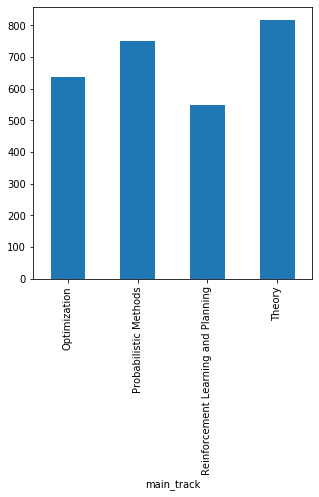

In [6]:
#plot distribution of main_tracks across papers

fig = plt.figure(figsize=(5,5))
df.groupby('main_track').text.count().plot.bar(ylim=0)
plt.show()

more balanced classes

#### preprocessing

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc

In [9]:
#encode the main_track column

lb = LabelEncoder()
df['main_track_encoded'] = lb.fit_transform(df['main_track'])

In [10]:
#create target and feature arrays

x = df['text'].copy()
y = df['main_track_encoded'].copy()

In [12]:
#convert feature text values to a tf-idf weighted DTM

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df =700, 
                        norm='l2', lowercase=True, encoding='utf-8',
                        ngram_range=(1, 4), stop_words='english')

Xtf = tfidf.fit_transform(x)

In [13]:
Xtf

<2756x15595 sparse matrix of type '<class 'numpy.float64'>'
	with 264000 stored elements in Compressed Sparse Row format>

In [14]:
#split the source array in test and train sets

x_train, x_test, y_train, y_test = train_test_split(Xtf, y, test_size=0.25, random_state=42)

In [15]:
#fit a multinomial NB model

mnb = MultinomialNB().fit(x_train, y_train)

In [16]:
#accuracy score

print(mnb.score(x_test, y_test))

0.7547169811320755


In [17]:
#performing 10-fold CV instead

bayes = MultinomialNB()
bayes.fit(Xtf,y)
cross_val_score(bayes, Xtf, y, cv=10)

array([0.8115942 , 0.82608696, 0.73188406, 0.76086957, 0.78985507,
       0.74275362, 0.74545455, 0.72363636, 0.74545455, 0.74909091])

In [18]:
#predict
bayes.fit(x_train, y_train)
y_pred = bayes.predict(x_test)

In [19]:
# get AUC score: from true positives and false positives

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred, pos_label=1)
rates = pd.DataFrame(dict(fpr=false_positive_rate, tpr=true_positive_rate))
roc_auc = auc(rates['fpr'], rates['tpr'])
print('AUC SVC: ', roc_auc)

AUC SVC:  0.3099747474747475


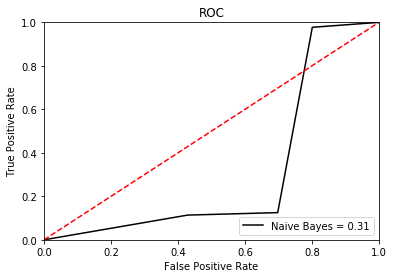

In [20]:
#ROC curve 

plt.plot(rates.fpr, rates.tpr, 'b',color='black', label = 'Naive Bayes = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC')
plt.legend(loc = 'lower right')
plt.show()

In [21]:
#confusion matrix for the NB classifier

cm = confusion_matrix(y_test, y_pred)

cm

array([[ 81,  20,   3,  47],
       [  4, 150,   2,  20],
       [  1,  12, 130,  14],
       [ 20,  21,   5, 159]], dtype=int64)

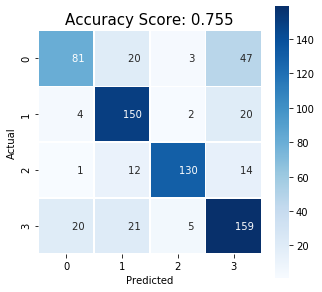

In [22]:
#plotting the confusion matrix

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt = "10.0f", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual');
plt.xlabel('Predicted');
all_sample_title = 'Accuracy Score: {0}'.format(round(np.mean(accuracy_score(y_test, y_pred)),3))
plt.title(all_sample_title, size = 15);

In [23]:
df[['main_track', 'main_track_encoded']].drop_duplicates().sort_values(by='main_track_encoded')

,main_track,main_track_encoded
214,Optimization,0
219,Probabilistic Methods,1
238,Reinforcement Learning and Planning,2
271,Theory,3


In [25]:
from xgboost import XGBClassifier

In [26]:
# fit model on training data
model = XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [27]:
# make predictions for test data
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]

In [28]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 73.88%
